# Neizrazito, evolucijsko i neuro računarstvo - 7. domaća zadaća

Ovdje se nalazi rješenje, a kasnije i izvješće za 7. domaću zadaću iz NENR-a.

<br><br>

## Učitavanje resursa

In [1]:
import os

In [2]:
from IPython.display import Image
from matplotlib import pyplot as plt
import numpy as np

In [3]:
import civilization.selection_strategies
import civilization.cross_strategies
import civilization.mutation_strategies
import civilization.initializers
import civilization.variable

from genetic_nn import GeneticNN

from util import parse_dataset

<br><br>

## Zadatak 1.

<br>

Razmotrite jedan neuron koji ima samo jedan ulaz. Njegov izlaz tada će biti određen izrazom:

$$
y = \frac{1}{1 + \frac{\left| x - w \right|}{\left| s \right|}}
$$

Pretpostavite da je u neuron pohranjena vrijednost $w = 2$. Nacrtajte *na istom grafu* ovisnost $y\left( x; w = 2 \right)$ za tri slučaja: za $s = 1$, za $s = 0.25$ te za $s = 4$ (svaku različitom bojom ili stilom linije). Za raspon apscise uzmite interval $\left[ -8, 10 \right]$. Razumijete li sada kako $s$ utječe na izlaz neurona $y$? Kako će izgledati izlaz neurona koji ima dva ulaza i što se tada kontrolira parametrima $s_1$ i $s_2$?

---

Ovaj zadatak riješit ćemo ovdje, bez uporabe **civilization** ili **minikeras** paketa.

In [4]:
def generate_function(w, s):
    def _y(inputs: np.ndarray):
        return np.reciprocal(1 + np.abs(np.divide(inputs - w, s)))
        
    return _y

In [5]:
task_1_ws = [2]
task_1_ss = [4, 1, 0.25]
task_1_x_interval = (-8, 10 + 1e-6)
task_1_x_axis = np.arange(*task_1_x_interval, 0.1)
task_1_x_ticks = np.arange(*task_1_x_interval, 1.)

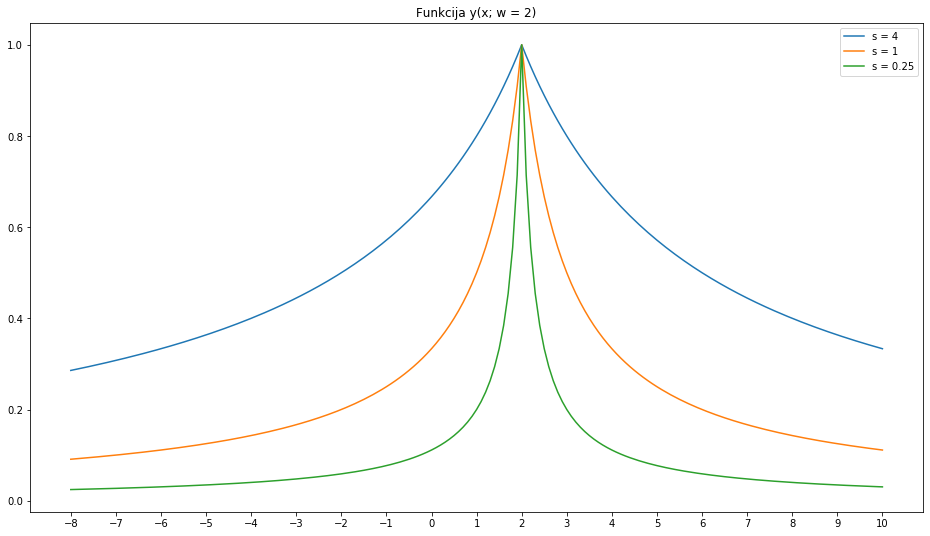

In [6]:
plt.figure(figsize=(16, 9))
plt.title(f"Funkcija y(x; w = 2)")

for w in task_1_ws:
    for s in task_1_ss:
        _function = generate_function(w, s)
        
        plt.xticks(task_1_x_ticks)
        plt.plot(task_1_x_axis, [_function(x) for x in task_1_x_axis], label=f"s = {s}")
        plt.legend()

<br><br>

## Zadatak 2.

<br>


Iskoristite neki gotov program (ili napišite vlasitit program, što god Vam je lakše) kako biste dobili 2D prikaz podataka koje ste dobili za učenje (`zad7-dataset.txt`). Pri tome uzorke različitih razreda prikažite ili različitim simbolom (npr. kvadratić, trokutić, kružič) ili različitom bojom. Ovu sliku spremite kao dio Vaše dokumentacije. Ako ste koristili gotov program, navedite naziv programa.

Proučite dobiveni prikaz. Postoji li kakav uzorak u tim podatcima? Jesu li razredi međusobno linearno odvojivi?


---

Ovaj zadatak ćemo lagano riješiti koristeći ```parse dataset``` iz **util.py** i ```plt.scatter```.

In [7]:
task_2_dataset = parse_dataset("data/dataset.tsv")
tr_x, tr_y = zip(*task_2_dataset)

scatter_y = np.array([1 if y[0] == 1 else 2 if y[1] == 1 else 3 for y in tr_y])
scatter_x = [[], [], []]

for i, x in enumerate(tr_x):
    scatter_x[scatter_y[i] - 1].append(x)

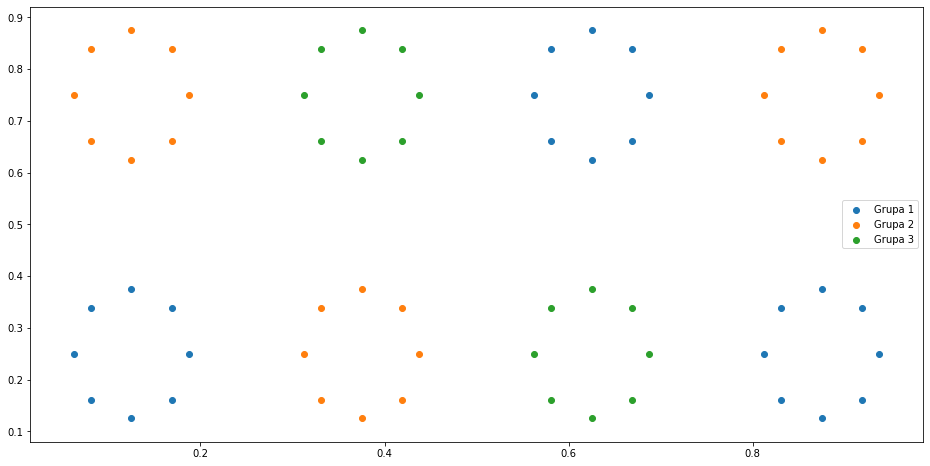

In [8]:
plt.figure(figsize=(16, 8))

for i, group in enumerate(scatter_x):
    plt.scatter(*zip(*group), label=f"Grupa {i + 1}")
    plt.legend()

<br><br>

## Zadatak 3.

<br>

Kada biste morali ručno odrediti vrijednosti svih parametara upravo zadane neuronske mreže, na koje biste ih vrijednosti postavili i zašto? Čime biste se vodili prilikom određivanja parametara neurona skrivenog sloja a čime prilikom određivanja parametara neurona izlaznog sloja? Nacrtajte tu neuronsku mrežu i na njoj prikažite vrijednosti svih parametara.

---

- Ulazni sloj
  - nema parametara, prema tome nemamo što postaviti
  
- Skriveni sloj
  - samo jedan sloj tipa $N_1$
  - postavljamo dva parametra: $\vec{w}$ ($2$ parametra) i $s$, i to njih $8$ (jer imamo $8$ neurona), što je ukupno $24$ parametara (tj. $\left( 2 + 1 \right) \cdot 8$ parametara)
  
- Izlazni sloj
  - Običan dense layer s $3$ izlaza, s obzirom na to da prethodni sloj ima $8$ neurona, ovaj sloj ima $24$ težina ($8 \cdot 3$ i $3$ varijable pomaka, ukupno $27$ težina.

### Skriveni sloj

Skrivenom sloju bi trebalo pronaći optimalno raspršenje. Pretpostavljam da će idealna konfiguracija za ovakvu mrežu imati isto raspršenje ($s$) za sve neurone jer je preplitka za bilo što više. Stoga, bit će bitno pronaći optimalne težine za $N_1$ sloj.

Moja pretpostavka je da se ovaj sloj ponaša kao neki izlučivač značajki. S obzirom da su mi dostupni podaci, mogu vidjeti da su dosta strukturirani. Imamo $8$ kružnica, pa ću parametre težina postaviti u središta tih kružnica (ne znam ih napamet, ne vidim ih od oka, neću investirati u pisanje programa koji ih pronalazi).

### Izlazni sloj

Izlazni sloj je jedan potpuno povezani sloj. On će dati $3$ vrijednosti koje, s obzirom da su aktivirane sigmoidom, možemo gledati kao vjerojatnost da je neka točka jedna od $3$ klase. S obzirom na to da smo skriveni sloj definirali kao središta kružnica, to će kao konsekvens imati činjenicu da će aktivacije neurona biti najveće za klasu u čijem se središtu nalaze. Prema tome, ovisno kako poredamo neurone ulaznog sloja, tako ćemo trebati i postaviti težine i pomak, kako bi osigurali da značajke koje je skriveni sloj izlučio najviše pridonesu povećanjem vrijednosti aktivacije neurona kojeg predstavljaju. Konačno, pomaci ovdje ne igraju preveliku ulogu, s obzirom da pomak može pridonijeti samo tome da malo popravi aktivaciju za određenu znamenku izlaza, ali što se tiče utjecaja jedne klase na drugu, tu nema nikakvog utjecaja. Što se mene tiče, pomaci mogu biti $0$. Ako nam je učenje dobro, predviđam da će nam za ovakav skup podataka pomaci biti **jednaki**, a težiti u $+\infty$.

Pretpostavimo da smo centre definirali s lijeva na desno, od gore prema dolje. Onda mogu reći da je raspodjela grupa sljedeća:

- grupa $1$: $\left[ 3, 5, 8 \right]$
- grupa $2$: $\left[ 1, 4, 6 \right]$
- grupa $3$: $\left[ 2, 7 \right]$

Recimo da su težine simboličke, tj. da promatramo samo njihov odnos. Reprezentirat ćemo ih s $0$ ili $1$, jer jednostavno, ako određena značajka nije centrirana u klasi koja nas interesira, možemo poništiti njezin doprinos, a one koje jesu priznati. Onda će matrica težina glasiti:

<br>

$$
\vec{w} = 
\begin{bmatrix}
0 & 1 & 0 \\
0 & 0 & 1 \\
1 & 0 & 0 \\
0 & 1 & 0 \\
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 \\
1 & 0 & 0 \\
\end{bmatrix}
$$

<br>

dok će težine biti vektor

<br>

$$
\vec{b} = \left[ x, x, x\right]
$$

<br>

gdje je x neki skalar za koji vrijedi

<br>

$$
{x \rightarrow +\infty}
$$

Finalno, da se uočiti da će za ovakvu mrežu skriveni sloj izlučivati značajke, tj. govoriti nam o prototipima klastera neke klase, dok će izlazni sloj poništavati aktivacije prethodnog sloja nevezane uz središta klase koju pokušavaju reprezentirati net sumom, a pomaci će naše vrijednosti, zbog korištenja sigmoide pokušati približiti vrijednosti $1$ što više mogu, ne bi li srednja kvadratna pogreška bili što manja.

Iz ovoga je također vidljivo da će optimalan trening ovakve mreže uključivati postavljanje $\vec{b} = \left[ 0, 0, 0\right]$ te zamrzavanje tih vrijednosti, pa će se pri kraju treninga zamrznuti svi ostali parametri, a trenirati $\vec{b}$ kako bi se minimizirala pogreška.

<br><br>

## Zadatak 4.

Naučite optimalne parametre mreže arhitekture $2 \times 8 \times 3$.

---

Prvo ćemo inicijalizirati parametre za našu mrežu:

In [9]:
tfv = civilization.variable.TrackingFunctionVariable

ts = civilization.selection_strategies.TournamentSelection

ac = civilization.cross_strategies.AveragingCross

cm = civilization.mutation_strategies.CompositeMutation
gm = civilization.mutation_strategies.GaussianMutation
grm = civilization.mutation_strategies.GaussianReplacementMutation

In [10]:
mutation_probability_1 = tfv(reference_value=0.,
                             function=lambda x, **y: (np.sin(x / 5) + 1.) * 0.25,
                             key_to_track="iteration")

mutation_probability_2 = tfv(reference_value=0,
                             function=lambda x, **y: (np.sin(x / 13) + 1.) * 0.125,
                             key_to_track="iteration")

mutation_probability_3 = tfv(reference_value=0,
                             function=lambda x, **y: (np.sin(x / 5) + 1.) * 0.05,
                             key_to_track="iteration")

mutation_intensity_1 = tfv(reference_value=0.,
                           function=lambda x, **y: (np.sin(x / 11) + 1.) * 0.25,
                           key_to_track="iteration")

mutation_intensity_2 = tfv(reference_value=0.,
                           function=lambda x, **y: (np.sin(x / 23) + 0.5),
                           key_to_track="iteration")

mutation_intensity_3 = tfv(reference_value=0.,
                           function=lambda x, **y: (np.sin(x / 11) + 1.) * 0.5,
                           key_to_track="iteration")

In [11]:
selection_strategy = ts()

In [12]:
cross_strategy = ac()

In [13]:
composite_mutation =\
[
    gm(probability=mutation_probability_1, intensity=mutation_intensity_1),
    gm(probability=mutation_probability_2, intensity=mutation_intensity_3),
    grm(probability=mutation_probability_3, intensity=mutation_intensity_3),
]

mutation_strategy = cm(mutation_strategies=composite_mutation, probabilities=np.array([0.975, 0.024, 0.001]))

In [14]:
task_4_population_count = civilization.variable.Constant(15)
task_4_epochs = 100000
task_4_verbose = 1

In [15]:
task_4_model = GeneticNN(sizes=(2, 8, 3),
                         selection_strategy=selection_strategy,
                         cross_strategy=cross_strategy,
                         mutation_strategy=mutation_strategy)

<br>

Naš model ima sljedeći izgled:

In [16]:
print(task_4_model.model.summary())

============================================  Model  ===========================================

       Layer Name              Layer Type              No. Params         No. Trainable Params  
------------------------------------------------------------------------------------------------
        [0] Input             Input (1 x 2)                 0                       0           
      [1] Distance          Distance (2 x 8)               24                      24           
       [2] Linear                Linear                     0                       0           
        [3] Dense             Dense (8 x 3)                27                      27           
       [4] Sigmoid               Sigmoid                    0                       0           

Total number of parameters:				51
Total number of trainable parameters:	51


---

In [17]:
task_4_best = task_4_model.fit(population_count=task_4_population_count,
                               epochs=task_4_epochs,
                               verbose=task_4_verbose)

print(f"Najbolji primjerak ima gubitak {task_4_best[0]:.06f}.")

100%|██████████| 100000/100000 [04:51<00:00, 342.86it/s]
Najbolji primjerak ima gubitak 0.583866.


---

### Podzadatak 1

Nacrtajte novu sliku na kojoj se vide svi ulazni uzorci s indikacijom razreda te uzorci koje je GA naučio za svaki neuron tipa $1$.

<br>

Prvih $24$ parametara su parametri sloja **Distance**. U njemu, prvih $16$ predstavljaju težine tj. središta, dok su preostali $\vec{s}$. Nacrtajmo ova središta uz originalni skup podataka.

In [18]:
task_4_distance_params = task_4_best[1][:24]

task_4_distance_weights = task_4_distance_params[:16]
task_4_distance_scale = task_4_distance_params[16:]

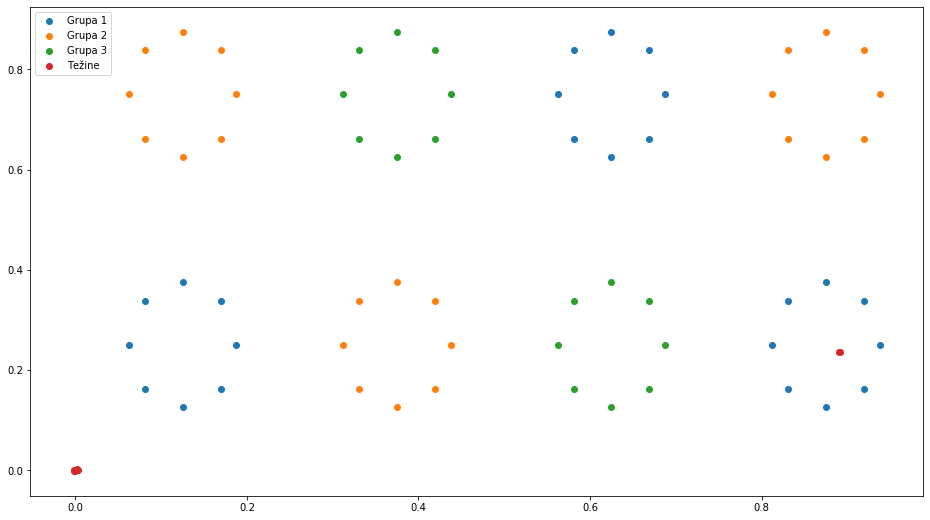

In [19]:
plt.figure(figsize=(16, 9))

for i, group in enumerate(scatter_x):
    plt.scatter(*zip(*group), label=f"Grupa {i + 1}")
    plt.legend()
    
task_4_weight_points = list(zip(*np.array(task_4_distance_weights).reshape(2, -1).T))
    
plt.scatter(*task_4_weight_points, label=f"Težine")
plt.legend();

---

### Podzadatak 2

Prokomentirajte gdje se nalaze naučeni uzorci i je li to u skladu s očekivanjem.

<br>

Pa baš i ne. Interesantno je što se puno uzoraka nalazi na $\left( x, y \right) = \left( 0, 0 \right)$. Ovo je najvjerojatnije zbog metode križanja, koja uprosječuje jedinke.

Vidimo da se grupe otprilike pomiču prema centrima krugova, što znači da razlog zašto mreža nije dobro istrenirana je radi neke suboptimalne značajke genetskog algoritma - konvergencija treba biti brža. Međutim, znamo da algoritam radi jer se pogreška smanjuje. Problem je što se to događa presporo.

---

### Podzadatak 3

Kakve je vrijednosti parametara $s_i$ naučio **GA**? Jesu li iste za $x$ i $y$ komponentu ili su različite? Objasnite!

<br>

Ups, inicijalno je pretpostavljeno da je s jednodimenzionalan (uzima se njegova norma, pa dimenzionalnost nije presudna i više od 1 dimenzije usporava trening bez teoretskih dobitaka). No, analizirat ćemo kakve su, barem. Vrijednosti $\vec{s}$ su vrijednosti od $16$. indeksa do $23$, a nazvali smo ih `task_4_distance_scale`.

In [20]:
print(f"s = {task_4_distance_scale}")

s = [-0.04906711  0.67924976 -0.02988746  0.02745205  0.0462234  -0.93919238
 -0.03255855  0.0297058 ]


<br>

Vidimo da su $1$., $2$. i $8$. vrijednost gotovo jednake. Isto možemo (približno) reći i za $2$., $5$. i $7$. vrijednost.

---

### Podzadatak 4

Nacrtajte novu sliku na kojoj se vide svi neuroni neuronske mreže, pozicije koje su naučene u neuronima tipa $1$ te vrijednosti težina za neurone tipa $2$.

<br>

Koristit ćemo jedne od naučenih parametara:

$$
\vec{w_d} =
    \begin{bmatrix}
        0.113  &  0.112  &  0.000  &  0.001  & -0.002  &  0.001  &  0.000  &  0.000 \\
        0.764  &  0.763  & -0.001  & -0.002  &  0.000  &  0.001  &  0.000  &  0.000
    \end{bmatrix}
$$

$$
\vec{s} =
    \begin{bmatrix}
        0.629  &  0.639  & -0.037  & -0.042  & -0.039  &  0.182  &  13.014 &  0.034
    \end{bmatrix}
$$

<br>

i parametre linearnog sloja

<br>

$$
\vec{w_l} =
    \begin{bmatrix}
    -0.404  & -0.870  &  2.194 \\
     0.153  & -0.865  &  0.770 \\
    -2.728  &  4.163  & -2.119 \\
    -4.393  &  3.555  & -2.269 \\
    -3.013  &  3.816  & -1.518 \\
    -2.152  & -0.232  &  1.061 \\
     0.063  &  1.014  & -0.137 \\
    -0.098  &  5.618  & -5.033
    \end{bmatrix}
$$

$$
\vec{b} =
    \begin{bmatrix}
    0.665  & -1.808  & -1.861
    \end{bmatrix}
$$

<br>

Možemo prikazati neuronsku mrežu slikom:

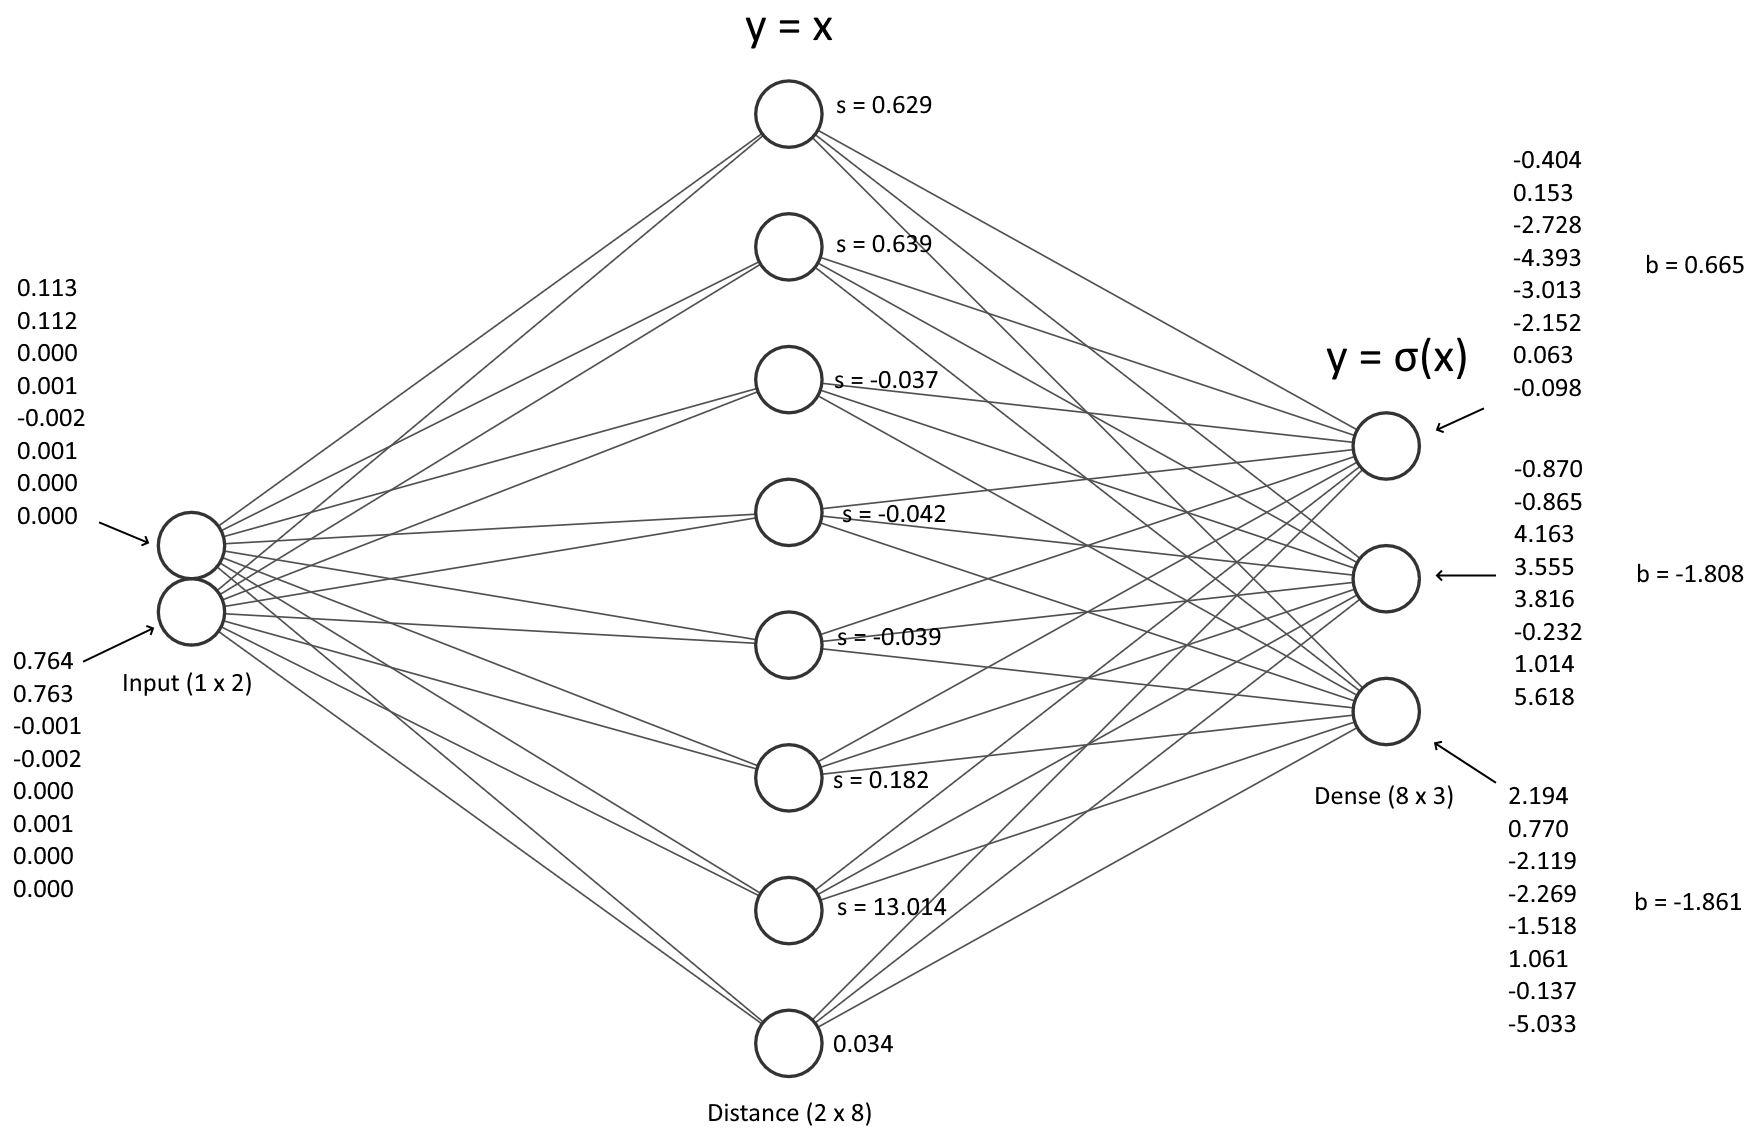

In [21]:
Image(filename="task_4_nn.png")

---

### Podzadatak 5

Uočavate li kakvu pravilnost u tim težinama? Možete li je objasniti?

<br>

#### Sloj udaljenosti

Uočavamo da je većina točaka u $\left( x, y \right) = \left( 0, 0 \right)$. One koje nisu imaju gotovo iste $x$ i $y$ komponente.

S druge strane, kod $\vec{s}$ imamo vrijednosti blizu $0.04$ za sve elemente osim $5$. i $6$., i u manjoj mjeri $7$. i $8$. Ovo je u skladu s očekivanjem da će za ovakvu arhitekturu mreže $\vec{s}$ imati elemente približno jednake.

---

#### Linearni sloj

Uočavamo da su određene težine velike magnitude dok su ostale blizu $0$. Ovo je u skladu s našom pretpostavkom da će težine zaslužene za značajke određene klase biti većeg apsolutnog iznosa, dok će ostale biti manjeg iznosa.

<br><br>

## Zadatak 5.

Naučite optimalne parametre mreže arhitekture $2 \times 8 \times 4 \times 3$.

In [22]:
task_5_population_count = civilization.variable.Constant(20)
task_5_epochs = 100000
task_5_verbose = 1

In [23]:
task_5_model = GeneticNN(sizes=(2, 8, 4, 3),
                         selection_strategy=selection_strategy,
                         cross_strategy=cross_strategy,
                         mutation_strategy=mutation_strategy)

<br>

Naš model ima sljedeći izgled

In [24]:
print(task_5_model.model.summary())

============================================  Model  ===========================================

       Layer Name              Layer Type              No. Params         No. Trainable Params  
------------------------------------------------------------------------------------------------
        [0] Input             Input (1 x 2)                 0                       0           
      [1] Distance          Distance (2 x 8)               24                      24           
       [2] Linear                Linear                     0                       0           
        [3] Dense             Dense (8 x 4)                36                      36           
       [4] Sigmoid               Sigmoid                    0                       0           
        [5] Dense             Dense (4 x 3)                15                      15           
       [6] Sigmoid               Sigmoid                    0                       0           

Total number of parameters:	

<br>

In [25]:
task_5_best = task_5_model.fit(population_count=task_5_population_count,
                               epochs=task_5_epochs,
                               verbose=task_5_verbose)

print(f"Najbolji primjerak ima gubitak {task_5_best[0]:.06f}.")

100%|██████████| 100000/100000 [05:29<00:00, 303.61it/s]
Najbolji primjerak ima gubitak 0.543487.


---

### Podzadatak 1

Je li postupak učenja trajao dulje ili kraće u odnosu na prethodnu arhitekturu? Možete li objasniti zašto?

<br>

Postupak učenja će, za postupak koji funkcionira, trajati dulje. Razlog tome je veći broj parametara uz istu populaciju. Ovo rezultira, ovisno o inicijalizatoru, jedinkama koje imaju manju kosinus udaljenost. Manja varijacija znači da je puno teže izaći iz lokalnog optimuma, što znači da mutacija ima teži posao i da joj generalno treba dulje da pronađe rješenje.

---

### Podzadatak 2

Pogledajte naučene parametre u neuronima tipa $1$ za ovaj slučaj. Možete li ih objasniti?

<br>

Parametri u neuronima tipa $1$ nalaze se na prvih $24$ mjesta najbolje jedinke, kao i u prethodnom zadatku.

In [26]:
task_5_distance_params = task_5_best[1][:24]

task_5_distance_weights = task_5_distance_params[:16]
task_5_distance_scale = task_5_distance_params[16:]

<br>

Prikazat ćemo težine uz skup podataka kao i prije:

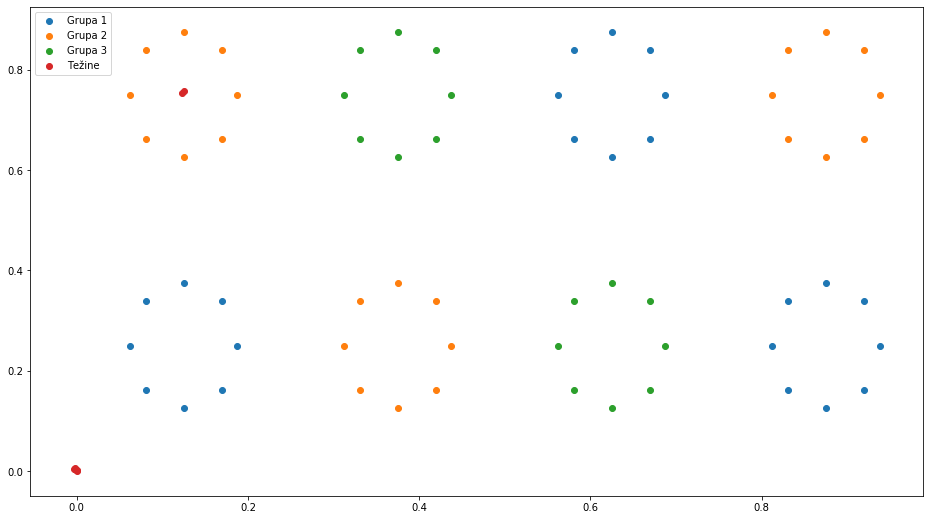

In [27]:
plt.figure(figsize=(16, 9))

for i, group in enumerate(scatter_x):
    plt.scatter(*zip(*group), label=f"Grupa {i + 1}")
    plt.legend()
    
task_5_weight_points = list(zip(*np.array(task_5_distance_weights).reshape(2, -1).T))
    
plt.scatter(*task_5_weight_points, label=f"Težine")
plt.legend();

<br>

Naučeni parametar $\vec{s}$ je:

In [28]:
print(task_5_distance_scale)

[ 0.07447736 -0.08232102  0.68971332 -0.08573142  0.07765383  0.10204302
  0.14926963  0.00312512]


<br><br>

## Zadatak 6.

Možete li dobiti ispravnu klasifikaciju svih uzoraka u arhitekturi koja ima $N_1 < 8$? Provjerite to na arhitekturi $2 \times 6 \times 4 \times 3$.

In [29]:
task_6_population_count = civilization.variable.Constant(20)
task_6_epochs = 100000
task_6_verbose = 1

In [30]:
task_6_model = GeneticNN(sizes=(2, 6, 4, 3),
                         selection_strategy=selection_strategy,
                         cross_strategy=cross_strategy,
                         mutation_strategy=mutation_strategy)

<br>

Naš model ima sljedeći izgled:

In [31]:
print(task_6_model.model.summary())

============================================  Model  ===========================================

       Layer Name              Layer Type              No. Params         No. Trainable Params  
------------------------------------------------------------------------------------------------
        [0] Input             Input (1 x 2)                 0                       0           
      [1] Distance          Distance (2 x 6)               18                      18           
       [2] Linear                Linear                     0                       0           
        [3] Dense             Dense (6 x 4)                28                      28           
       [4] Sigmoid               Sigmoid                    0                       0           
        [5] Dense             Dense (4 x 3)                15                      15           
       [6] Sigmoid               Sigmoid                    0                       0           

Total number of parameters:	

<br>

In [32]:
task_6_best = task_6_model.fit(population_count=task_6_population_count,
                               epochs=task_6_epochs,
                               verbose=task_6_verbose)

print(f"Najbolji primjerak ima gubitak {task_6_best[0]:.06f}.")

100%|██████████| 100000/100000 [05:27<00:00, 305.26it/s]
Najbolji primjerak ima gubitak 0.531967.


---

### Podzadatak 1

Na kraju (uspješnog ili neuspješnog) postupka učenja pogledajte za najbolje rješenje parametre u neuronima tipa $1$ za ovaj slučaj.

<br>

Ti neuroni se nalaze u prvih $12$ vrijednosti najbolje jedinke

In [33]:
task_6_distance_weights = task_6_best[1][:12]

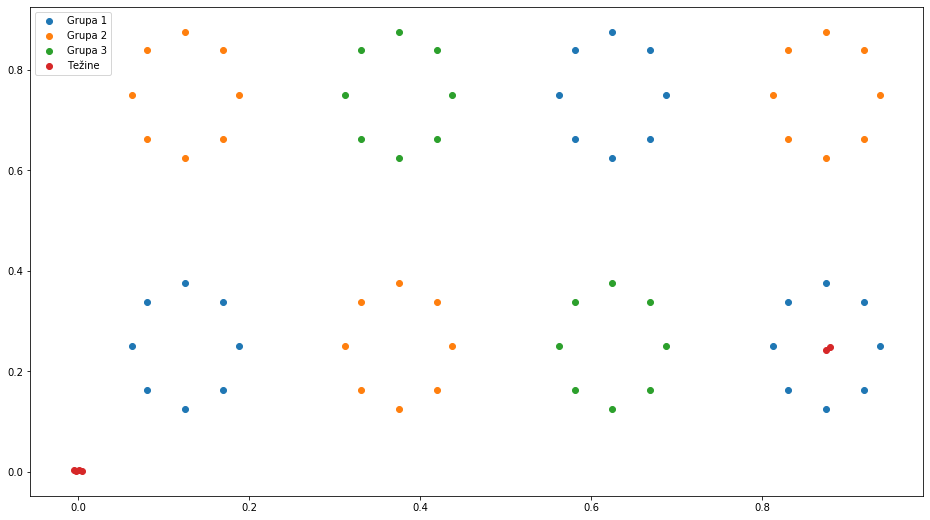

In [34]:
plt.figure(figsize=(16, 9))

for i, group in enumerate(scatter_x):
    plt.scatter(*zip(*group), label=f"Grupa {i + 1}")
    plt.legend()
    
task_6_weight_points = list(zip(*np.array(task_6_distance_weights).reshape(2, -1).T))
    
plt.scatter(*task_6_weight_points, label=f"Težine")
plt.legend();

---

### Podzadatak 2

Što smo izgubili u odnosu na mrežu iz zadatka $4$?

<br>

Teoretski bi trebali izgubiti to da su težine sloja udaljenosti centri krugova, jer imamo manji broj potencijalnih centara od ukupnog broja centara.